# Fama-MacBeth Regression #

### Size, Value and Beta ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [3]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = {}

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df[['Adjusted_close', 'Company Market Cap']]

        df = df.rename(columns={
            'Adjusted_close':'adj_close',
            'Company Market Cap':'market_cap',
        })

        # Fill nans
        df['adj_close'] = df['adj_close'].interpolate(method='time')
        df['market_cap'] = df['market_cap'].interpolate(method='time')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [4]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

In [5]:
# Get the important data for the Betas

ff_betas = pd.read_csv(r"..\additional_data\famafrench_betas.csv")
ff_betas = ff_betas.rename(columns={'Unnamed: 0': 'ticker'})
ff_betas.set_index('ticker', inplace = True)

ff_betas

,capm_beta,smb_beta,hml_beta
ticker,,,
A,0.961191,0.607780,-0.342912
AAPL,1.219488,-0.176535,-0.455694
ABBV,0.655835,-0.747669,0.211433
ABT,0.832462,-0.401419,-0.157432
ADBE,1.320948,-0.146993,-0.939163
...,...,...,...
XYL,1.011283,0.705327,0.127746
YUM,0.718007,0.512447,0.039782
ZBH,0.792854,0.795060,0.260779


In [6]:
# Create a DataFrame
mkt_cap_dict = {}

# Recorrer cada ticker y DataFrame
for ticker, df in dataframes.items():
    
    mkt_cap_dict[ticker] = df['market_cap']

mkt_cap_df = pd.DataFrame.from_dict(mkt_cap_dict)

mkt_cap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.361071e+10,6.524300e+11,1.049925e+11,6.806173e+10,3.582940e+10,1.705680e+10,3.108389e+10,4.076272e+10,1.325762e+10,1.091700e+10,...,3.680728e+09,1.913648e+10,1.510619e+10,1.829572e+10,3.869121e+11,6.925782e+09,3.213822e+10,2.001932e+10,4.101238e+09,2.171238e+10
2015-01-05,1.344976e+10,6.363537e+11,1.030167e+11,6.863393e+10,3.547031e+10,1.688536e+10,3.069550e+10,4.056267e+10,1.303465e+10,1.087333e+10,...,3.687124e+09,1.916268e+10,1.504639e+10,1.813390e+10,3.794763e+11,6.494739e+09,3.189760e+10,2.006674e+10,4.107349e+09,2.158203e+10
2015-01-06,1.326198e+10,6.420037e+11,1.025068e+11,6.717332e+10,3.520598e+10,1.669210e+10,3.074007e+10,4.048313e+10,1.304603e+10,1.096795e+10,...,3.729766e+09,1.922556e+10,1.518321e+10,1.828055e+10,3.780900e+11,6.456545e+09,3.176635e+10,2.011077e+10,4.203082e+09,2.137148e+10
2015-01-07,1.309767e+10,6.395573e+11,1.066497e+11,6.667641e+10,3.490673e+10,1.667963e+10,3.021161e+10,4.036503e+10,1.283443e+10,1.106984e+10,...,3.669356e+09,1.909456e+10,1.506058e+10,1.844237e+10,3.769977e+11,6.507470e+09,3.163511e+10,1.984488e+10,4.136374e+09,2.181264e+10
2015-01-08,1.274558e+10,6.221996e+11,1.077652e+11,6.617950e+10,3.505636e+10,1.643649e+10,3.005880e+10,4.034815e+10,1.267517e+10,1.117173e+10,...,3.612500e+09,1.905788e+10,1.496430e+10,1.860419e+10,3.737210e+11,6.556576e+09,3.125886e+10,1.947230e+10,4.138921e+09,2.214853e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,3.779508e+10,3.548646e+12,3.334150e+11,1.984701e+11,2.117538e+11,1.142630e+11,2.736885e+10,1.168177e+11,6.160180e+10,2.351189e+10,...,2.248062e+10,2.321429e+10,1.094599e+10,3.594764e+10,5.282521e+11,3.190884e+10,3.791791e+10,2.109839e+10,1.875359e+10,8.585769e+10
2024-10-23,3.779508e+10,3.548646e+12,3.318607e+11,1.984701e+11,2.117538e+11,1.142630e+11,2.736885e+10,1.168177e+11,6.160180e+10,2.351189e+10,...,2.248062e+10,2.321429e+10,1.094599e+10,3.594764e+10,5.282521e+11,3.199385e+10,3.791791e+10,2.109839e+10,1.875359e+10,8.562211e+10
2024-10-24,3.779508e+10,3.548646e+12,3.349871e+11,1.984701e+11,2.117538e+11,1.142630e+11,2.736885e+10,1.168177e+11,6.160180e+10,2.351189e+10,...,2.248062e+10,2.321429e+10,1.094599e+10,3.594764e+10,5.282521e+11,3.173396e+10,3.791791e+10,2.109839e+10,1.875359e+10,8.222875e+10


In [7]:
# Let us obtain the betas of each stock

returns_dic = {}

for ticker, df in dataframes.items():
    
    returns_dic[ticker] = df['adj_close'].pct_change(1)

returns_df = pd.DataFrame.from_dict(returns_dic)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.000617,0.001031,0.000569,0.000489,0.000984,0.000772,0.000184,0.000615,0.000900,0.000360,...,0.000900,0.000185,0.000324,0.000326,0.000256,0.000641,0.000499,0.000125,0.000940,0.000718
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [8]:
# Intersec Dates
common_dates = returns_df.index.intersection(mkt_cap_df.index)

# Filter for common dates
mkt_cap_df = mkt_cap_df.loc[common_dates]
returns_df = returns_df.loc[common_dates]

In [9]:
# Initialize lists to store results
betas_list = []

# Loop over each available date in the returns DataFrame
for date in common_dates:
    # Cross-section of market caps, returns, and betas for that specific date
    weights = np.sqrt(mkt_cap_df.loc[date])
    weights = weights / weights.sum()

    rets = pd.DataFrame([returns_df.loc[date]], index=['returns']).transpose()
    
    # Merge returns with characteristics
    reg_df_data = pd.concat([rets, ff_betas], axis=1).dropna()

    # Define independent (X) and dependent (y) variables
    X = sm.add_constant(reg_df_data[['capm_beta', 'smb_beta', 'hml_beta']])  
    y = reg_df_data['returns']  

    # Run the weighted least squares (WLS) regression
    model = sm.WLS(y, X, missing='drop', weights=weights)
    results = model.fit()

    # Extract coefficients, t-stats, and p-values
    params = results.params

    # Store results in separate lists
    betas_list.append(pd.Series(params, name=date)) 

# Convert lists to DataFrames
history_betas_df = pd.DataFrame(betas_list)

# Set the index as the dates
history_betas_df.index = common_dates


In [10]:
# Check the DataFrames

history_betas_df

,const,capm_beta,smb_beta,hml_beta
Date,,,,
2015-01-02,-0.000029,0.000698,-0.000031,-0.000297
2015-01-05,0.007799,-0.024212,0.000266,-0.009283
2015-01-06,0.015989,-0.026767,0.000483,-0.002345
2015-01-07,0.023985,-0.012480,0.002371,-0.003371
2015-01-08,0.008579,0.010696,-0.000400,-0.000829
...,...,...,...,...
2024-10-22,-0.009884,0.008844,-0.005412,0.003080
2024-10-23,0.010530,-0.016560,0.000388,0.004919
2024-10-24,-0.015144,0.016361,0.004741,-0.006065


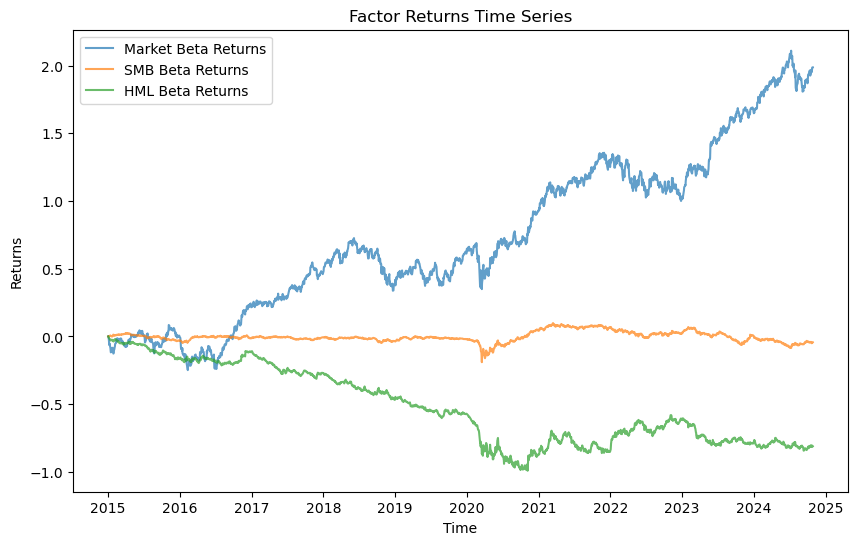

In [11]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(history_betas_df['capm_beta'].cumsum(), label='Market Beta Returns', alpha=0.7)
plt.plot(history_betas_df['smb_beta'].cumsum(), label='SMB Beta Returns', alpha=0.7)
plt.plot(history_betas_df['hml_beta'].cumsum(), label='HML Beta Returns', alpha=0.7)

# Config
plt.title('Factor Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

In [12]:
# Get the data for the SMB Premium
SMB = pd.read_csv(r"..\additional_data\SMB.csv")
SMB = SMB.set_index('Date')
SMB.index = pd.to_datetime(SMB.index)

# Get the data for the HML Premium
HML = pd.read_csv(r"..\additional_data\HML.csv")
HML = HML.set_index('Date')
HML.index = pd.to_datetime(HML.index)

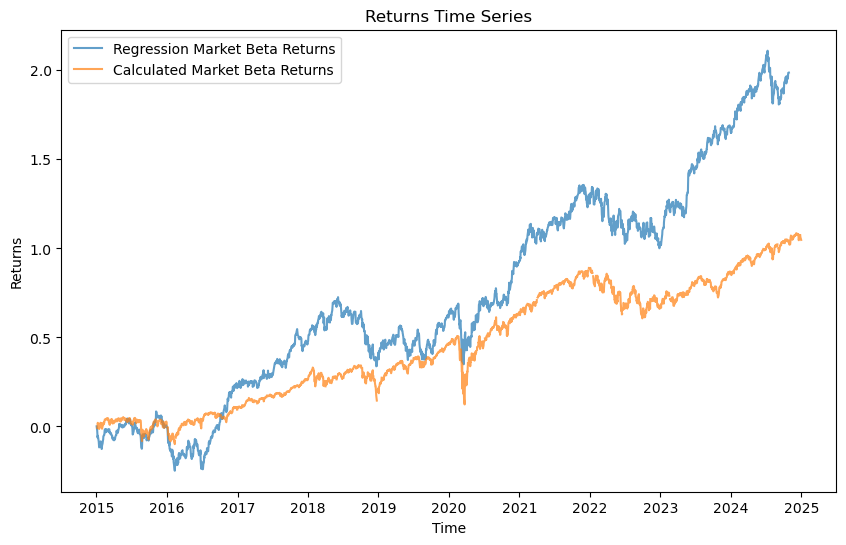

In [13]:
# Create the Plot
# Create the data
daily_rfr = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
benchmark_returns = sp500['sp_500'].pct_change(1)

# Create the Excess Returns
market_excess_returns = benchmark_returns - daily_rfr

plt.figure(figsize=(10, 6))
plt.plot(history_betas_df['capm_beta'].cumsum(), label='Regression Market Beta Returns', alpha=0.7)
plt.plot(market_excess_returns.cumsum(), label='Calculated Market Beta Returns', alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

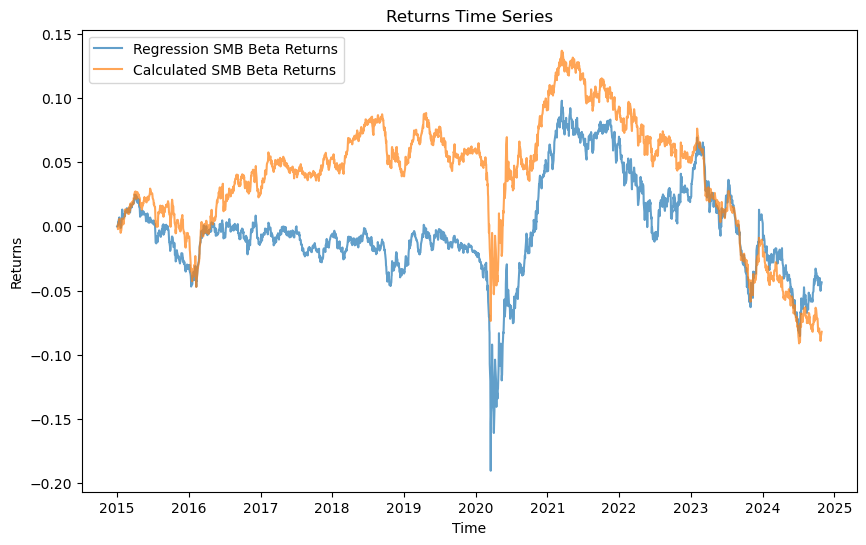

In [14]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(history_betas_df['smb_beta'].cumsum(), label='Regression SMB Beta Returns', alpha=0.7)
plt.plot(SMB.cumsum(), label='Calculated SMB Beta Returns', alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

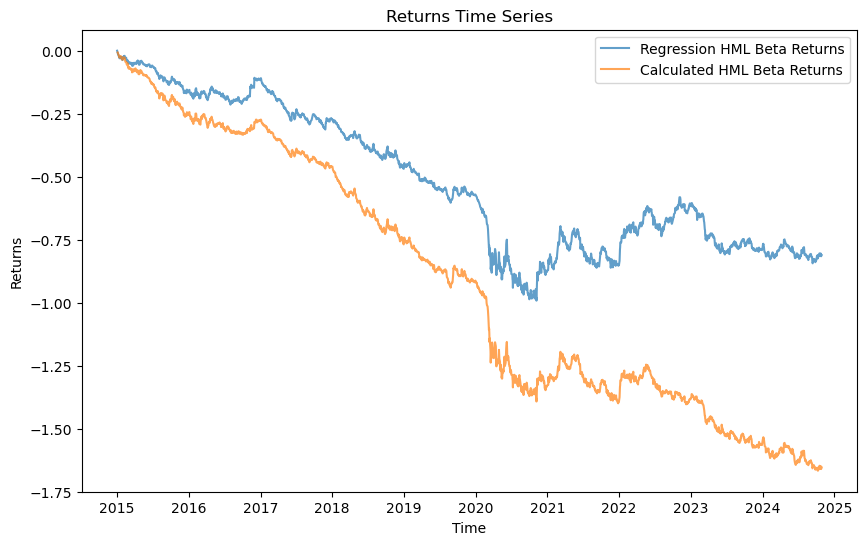

In [15]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(history_betas_df['hml_beta'].cumsum(), label='Regression HML Beta Returns', alpha=0.7)
plt.plot(HML.cumsum(), label='Calculated HML Beta Returns', alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

In [16]:
# Lets test the significance of these coefficients
def newey_west_std(errors, lag=4):
    """
    Computes Newey-West standard errors for a time series.
    
    Parameters:
    errors: Pandas Series or NumPy array of residuals (gamma estimates)
    lag: Maximum number of lags to consider (default: 4)
    
    Returns:
    Newey-West adjusted standard error
    """
    T = len(errors)
    gamma_var = errors.var()  # Start with variance of the series
    
    for l in range(1, lag + 1):
        weight = 1 - (l / (lag + 1))
        autocov = np.cov(errors[:-l], errors[l:])[0, 1]  # Autocovariance at lag l
        gamma_var += 2 * weight * autocov  # Newey-West adjustment

    return np.sqrt(gamma_var / T)  # Standard error

def fama_macbeth_significance_test(gamma_series, lag=4):
    """
    Performs statistical significance tests for Fama-MacBeth risk premia.

    Parameters:
    gamma_series: DataFrame where each column contains estimated gammas over time.
    lag: Lags for Newey-West standard errors (default: 4).

    Returns:
    DataFrame with mean gamma, standard error, t-statistics, and p-values.
    """
    gamma_means = gamma_series.mean()

    # Compute Newey-West adjusted standard errors
    gamma_std = gamma_series.apply(newey_west_std, lag=lag)

    # Compute t-statistics
    t_stats = gamma_means / gamma_std

    # Compute p-values
    p_values = 2 * (1 - stats.t.cdf(abs(t_stats), df=len(gamma_series) - 1))

    # Create results DataFrame
    results = pd.DataFrame({
        'Mean Gamma': gamma_means,
        'Std Error': gamma_std,
        't-stat': t_stats,
        'p-value': p_values
    })

    return results


In [17]:
# Now the Results

results = fama_macbeth_significance_test(history_betas_df[['capm_beta',	'smb_beta',	'hml_beta']])

results

,Mean Gamma,Std Error,t-stat,p-value
capm_beta,0.000804,0.000321,2.504082,0.012341
smb_beta,-0.000018,0.000080,-0.219241,0.826480
hml_beta,-0.000328,0.000157,-2.087247,0.036968


In [18]:
# Chi^2 test sobre alphas
# está en el paper de FF